# Subcluster merging
Pijuan-Sala, B., Griffiths, J.A., Guibentif, C., et al.

02 September 2018

## Setting up 

In [45]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as pl
import scanpy.api as sc
import pandas as pd
import matplotlib.pyplot as plt

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=100, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

#Set working directory
wd = '/path/to/working/directory'


results_file = './write/Embryo10Xv6_genes_PCAbatchCorrected.h5ad'
results_fileMerged = './write/Embryo10Xv6_genes_PCAbatchCorrected_mergedAGA.h5ad'



scanpy==1.2.2 anndata==0.6.9 numpy==1.14.3 scipy==1.1.0 pandas==0.23.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


## Read files

In [2]:
##====== Read normalised counts ======##

filename_data = wd + 'data/countsData_norm.mtx'
filename_gene_names = wd + 'data/genes.txt'
filename_barcodes = wd + 'data/cells.txt'
#filename_clustersAll = wd + 'data/cellTypes_20180215.txt'
print('reading counts')
adata_all_cells = sc.read(filename_data, cache=True).transpose()
print('reading genes')
adata_all_cells.var_names = np.genfromtxt(filename_gene_names, dtype='str')
print('reading cells')
adata_all_cells.obs_names = np.genfromtxt(filename_barcodes, dtype='str')

reading counts
... reading from cache file ./cache/rds-user-bp382-rds-bg200-hphi-gottgens-users-bp382-PhD_BPS32-release6-data-countsData_norm.h5ad
reading genes
reading cells


In [3]:
##====== Substitute gene IDs for geneNames ======##

genes = np.genfromtxt(filename_gene_names, dtype='str')

geneNameFilename = wd + 'data/rawData/genes.tsv'
geneName = pd.read_table(geneNameFilename,delimiter="\t",header=None,names=["geneID","geneName"])

geneName = geneName.set_index(geneName.geneID)
#print(metadata[adata.smp_names,:])
geneNameData = geneName.loc[genes,'geneName']
adata_all_cells.var_names = geneNameData
adata_all_cells.var['geneID'] = genes

print(adata_all_cells.var_names)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Sox17', 'Gm37323', 'Mrpl15',
       'Lypla1', 'Gm37988', 'Tcea1',
       ...
       'AC125149.1', 'AC125149.2', 'AC125149.4', 'AC234645.1', 'AC168977.2',
       'AC168977.1', 'AC149090.1', 'DHRSX', 'Vmn2r122', 'CAAA01147332.1'],
      dtype='object', name='geneName', length=29452)


In [3]:
##====== Check number of total cells -rows- ======##

adata_all_cells.shape

(139331, 29452)

In [4]:
##====== Read metadata file and set index to cell ======##

metadataFilename = wd + 'data/rawData/meta.tab'
meta = pd.read_table(metadataFilename,delimiter="\t",header=0)
meta = meta.set_index(meta.cell)


In [5]:
##======  Check number of total cells in metadata ======##

meta.shape

(139331, 13)

In [6]:
##======  Filter metadata so that the cells correspond to those in the counts matrix ======##


metadata00 = pd.DataFrame(np.array(meta)[np.array([cell in adata_all_cells.obs_names for cell in meta['cell']]),:])
metadata00.columns = meta.columns 

metadata00 = metadata00.set_index(metadata00.cell)
metadata00.shape

(139331, 13)

In [7]:
##======  Check columns in metadata ======##

metadata00.columns 

Index(['cell', 'barcode', 'sample', 'stage', 'batch', 'theiler',
       'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage',
       'cluster.theiler', 'stripped'],
      dtype='object')

In [8]:
##======  Add metadata to adata ======##

adata_all_cells.obs['sample'] = list(metadata00.loc[:,'sample'])
adata_all_cells.obs['stage'] = list(metadata00.loc[:,'stage'])
adata_all_cells.obs['batch'] = list(metadata00.loc[:,'batch'])
adata_all_cells.obs['theiler'] = list(metadata00.loc[:,'theiler'])
adata_all_cells.obs['doub.density'] = list(metadata00.loc[:,'doub.density'])
adata_all_cells.obs['doublet'] = list(metadata00.loc[:,'doublet'])
adata_all_cells.obs['cluster'] = list(metadata00.loc[:,'cluster'])
adata_all_cells.obs['clustersub'] = list(metadata00.loc[:,'cluster.sub'])
adata_all_cells.obs['clusterstage'] = list(metadata00.loc[:,'cluster.stage'])
adata_all_cells.obs['clustertheiler'] = list(metadata00.loc[:,'cluster.theiler'])
adata_all_cells.obs['stripped'] = list(metadata00.loc[:,'stripped'])
adata_all_cells.obs['clusterIdx'] = list(metadata00.loc[:,'cluster']-1)
adata_all_cells.obs['clustercat'] = ['cluster'+ str(name) for name in list(metadata00.loc[:,'cluster'])]


In [9]:
##======  Read batch corrected PCA ======##

PCAfilename = wd + 'data/rawData/PCAall_20180830.mtx'
filename_cells = wd + 'data/rawData/PCAall_cellnames_2018830.tab'
#filename_clustersAll = wd + 'data/cellTypes_20180215.txt'
print('reading counts')
adataPCA = sc.read(PCAfilename, cache=True).transpose()
#print('reading genes')
#adata_all_genes.var_names = np.genfromtxt(filename_gene_names, dtype='str')
print('reading cells')
adataPCA.obs_names = np.genfromtxt(filename_cells, dtype='str')
adataPCA.shape


reading counts
... reading from cache file ./cache/rds-user-bp382-rds-bg200-hphi-gottgens-users-bp382-PhD_BPS32-release6-data-rawData-PCAall_20180830.h5ad
reading cells


(116312, 50)

In [10]:
##======  Filter those cells that are in PCA - these will be the passed-QC cells ======##

adata = adata_all_cells[np.array([cell in adataPCA.obs_names for cell in adata_all_cells.obs_names]),:]

In [11]:
##======  Check how many cells passed QC ======##

adata.shape 

(116312, 29452)

In [12]:
##======  Add batch corrected PCA to adata object ======##

adata.obsm['X_pca'] = adataPCA.X.todense()

In [13]:
del adataPCA
del adata_all_cells

In [14]:
##======  Filter out stripped nuclei - they should be already filtered out but just in case ======##

metadata0 = pd.DataFrame(np.array(meta)[np.array([cell == False for cell in meta['stripped']]),:])
metadata0.columns = meta.columns 

metadata0 = metadata0.set_index(metadata0.cell)
#metadata0

In [15]:
##======  Filter out doublets - they should be already filtered out but just in case ======##

metadata1 = pd.DataFrame(np.array(metadata0)[np.array([cell == False for cell in metadata0['doublet']]),:])
metadata1.columns = metadata0.columns 

metadata1 = metadata1.set_index(metadata1.cell)
#metadata1

In [16]:
##======  Filter out these cells in adata - you should see they are the same dimensions ======##

adata = adata[np.array([cell in metadata0['cell'] for cell in adata.obs_names]),:]
adata.shape

(116312, 29452)

In [17]:
##======  Make cluster names of the clustersub column unique ======##

stringClust = list()
for i in range(0,len(adata.obs['cluster'])):
    stringClust.append(str(int(adata.obs['cluster'][i]))+str(int(adata.obs['clustersub'][i])))

adata.obs['clusterSubUnique'] = stringClust

In [26]:
##======  Read tSNE file ======##

tSNEfilename = wd + 'data/blanca_tsne.tab'
tSNE = pd.read_table(tSNEfilename,delimiter="\t",header=None,names=["tsne1","tsne2","cluster","celltype"])

In [27]:
##======  Add tSNE to adata ======##

adata.obs['tsne1'] = list(tSNE['tsne1'])
adata.obs['tsne2'] = list(tSNE['tsne2'])
adata.obs['clustertsne'] = list(tSNE['cluster'])
adata.obs['celltype'] = list(tSNE['celltype'])

tsne_x = [float(i) for i in tSNE.loc[:,'tsne1']]
tsne_y = [float(i) for i in tSNE.loc[:,'tsne2']]

coords_matrix = np.array([tsne_x, tsne_y])
print(coords_matrix.T.shape)
#Add coordinates in to adata file
adata.obsm['X_tsne'] = np.array(coords_matrix.T)




(116312, 2)


In [28]:
##======  Read tSNE file ======##

UMAPfilename = wd + 'data/umap.tab'
UMAP = pd.read_table(UMAPfilename,delimiter="\t",header=None,names=["umap1","umap2"])

UMAP_x = [float(i) for i in UMAP.loc[:,'umap1']]
UMAP_y = [float(i) for i in UMAP.loc[:,'umap2']]

coords_matrix = np.array([UMAP_x, UMAP_y])
print(coords_matrix.T.shape)
#Add coordinates in to adata file
adata.obsm['X_umap'] = np.array(coords_matrix.T)



(116312, 2)


In [29]:
##======  Check cell types ======##

np.unique(adata.obs['celltype'])

array(['Allantois', 'Cardiac mesenchyme', 'Cardiomyocytes',
       'Cranial neural crest', 'Def. endoderm', 'Early mixed mesoderm',
       'Early neurectoderm', 'Early paraxial mesoderm',
       'Early posterior mesoderm', 'Endothelium', 'Epiblast',
       'Erythroid 1', 'Erythroid 2', 'ExE ectoderm 1', 'ExE ectoderm 2',
       'ExE endoderm', 'ExE mesoderm', 'Forebrain', 'Foregut',
       'Haemato-endothelial progenitors', 'Intermediate mesoderm',
       'Late paraxial mesoderm', 'Midbrain/Hindbrain', 'Midgut/Hindgut',
       'NMP', 'New', 'Notochord', 'PGC', 'Parietal endoderm',
       'Pharyngeal mesoderm', 'Placodes', 'Primitive Streak', 'Somites',
       'Spinal cord', 'Surface ectoderm', 'Trunk neural crest',
       'Visceral endoderm'], dtype=object)

In [30]:
##======  Write results ======##

sc.write(results_file,adata)


## Generate colour palettes

In [31]:
##======  Read adata object ======##

adata = sc.read(results_file)

In [32]:
##====== Create colour palette for cell types ======##

all_colours = {
    "Allantois" : "#532C8A",#[32] "Allantois"                                   
    "Cardiac mesenchyme" :  "#F7901D",#[23] "Cardiac mesenchyme"                          
    "Cardiomyocytes" :  "#B51D8D",#[34] "Cardiomyocytes"                              
    "Def. endoderm" : "#F397C0",#[24] "Def. endoderm"    
    "Early mixed mesoderm" :  "#C594BF",#[7] "Early mixed mesoderm"                        
    "Early posterior mesoderm" :  "#DFCDE4",#[26] "Early ExE mesoderm"    
    "Early neurectoderm" :  "#A0CC47",#[10] "Early neurectoderm"                              
    "Early paraxial mesoderm" :  "#3F84AA",#[17] "Early paraxial mesoderm"                     
    "Endothelium" :  "#B3793B",#[20] "Endothelium"                                 
    "Epiblast" :  "#683612",#[1] "Epiblast"  
    "Erythroid 1" :  "#C72228",#[15] "Erythroid 1"                                 
    "Erythroid 2" :  "#EF4E22",#[37] "Erythroid2"                                  
    "ExE ectoderm 1" :  "#989898",#[30] "ExE ectoderm 1"                              
    "ExE ectoderm 2" :  "#333333",#[4] "ExE ectoderm 2"                              
    "ExE endoderm" : "#7F6874",#[5] "ExE endoderm"                                
    "ExE mesoderm" :  "#7253A2",#[12] "ExE mesoderm"                                
    "Forebrain" :  "#65A83E",#[8] "Forebrain"   
    "Foregut" :  "#EF5A9D",#[19] "Foregut"                                     
    "Haemato-endothelial progenitors" :  "#FBBE92",#[9] "Hemato-endothelial progenitors"              
    "Intermediate mesoderm" :  "#139992",#[31] "Intermediate mesoderm"                       
    "Pharyngeal mesoderm" :  "#C9EBFB",#[13] "Late mixed mesoderm"                         
    "Late paraxial mesoderm" :  "#8DB5CE",#[33] "Late paraxial mesoderm (presomitic mesoderm)"
    "Midgut/Hindgut":  "#CE4E82",#[35] "Midgut/Hindgut"                              
    "Midbrain/Hindbrain" :  "#354E23",#[11] "Midbrain/Hindbrain"                          
    "Trunk neural crest" :  "#77783C",#[18] "Neural crest"
    "NMP" :  "#8EC792",#[14] "NMPs"                                         
    "Notochord" :  "#0F4A9C",#[21] "Notochord"                                   
    "PGC" :  "#FACB12",#[25] "PGC"                                         
    "Placodes" :  "#BBDCA8",#[27] "Placodes"                                    
    "Parietal endoderm" :  "#1A1A1A",#[29] "Parietal endoderm"                           
    "Cranial neural crest" :  "#C3C388",#[36] "Pre-migratory neural crest"                  
    "Primitive Streak" :  "#DABE99",#[2] "Primitive Streak"    
    "Somites" :  "#005579",#[16] "Somites"                                     
    "Spinal cord" :  "#CDE088",#[38] "Spinal cord"                                 
    "Surface ectoderm" : "#FFF574",#[22] "Surface ectoderm"                            
    "Visceral endoderm" : "#F6BFCB",#[3] "Visceral endoderm"   
    "New": "gray"

}#light green


               

colPalette = [all_colours[i] for i in sorted(np.unique(adata.obs['celltype']))]


In [33]:
##====== Create colour palettes for stages ======##

bluePal = [ "#E3FCFA","#C1ECEF", "#A3D4E3", "#86B8D6","#6C98CA","#5476BE","#3E52B1","#2B2DA5","#2B1999"]

spectralPal = [ "#D53E4F","#F46D43","#FDAE61","#FFFFBF","#FEE08B","#E6F598","#ABDDA4","#3288BD", "#66C2A5","#A9A9A9"]

In [34]:
##====== Create colour palette for gene expression profiles ======##

from matplotlib.colors import LinearSegmentedColormap
rmap = LinearSegmentedColormap.from_list(name='gene_cmap',
                                         colors=['lightgrey', 'thistle', 'red', 'darkred'])

cmap = LinearSegmentedColormap.from_list(name='gene_cmap',
                                         colors=["#BFBFBF","#6495ED","#000000"])



## Generate plots to check cell types, time-points and gene expression profiles

In [35]:
##======  Read adata object ======##

adata = sc.read(results_file)

saving figure to file ./figures/tsnetsne_celltype.png


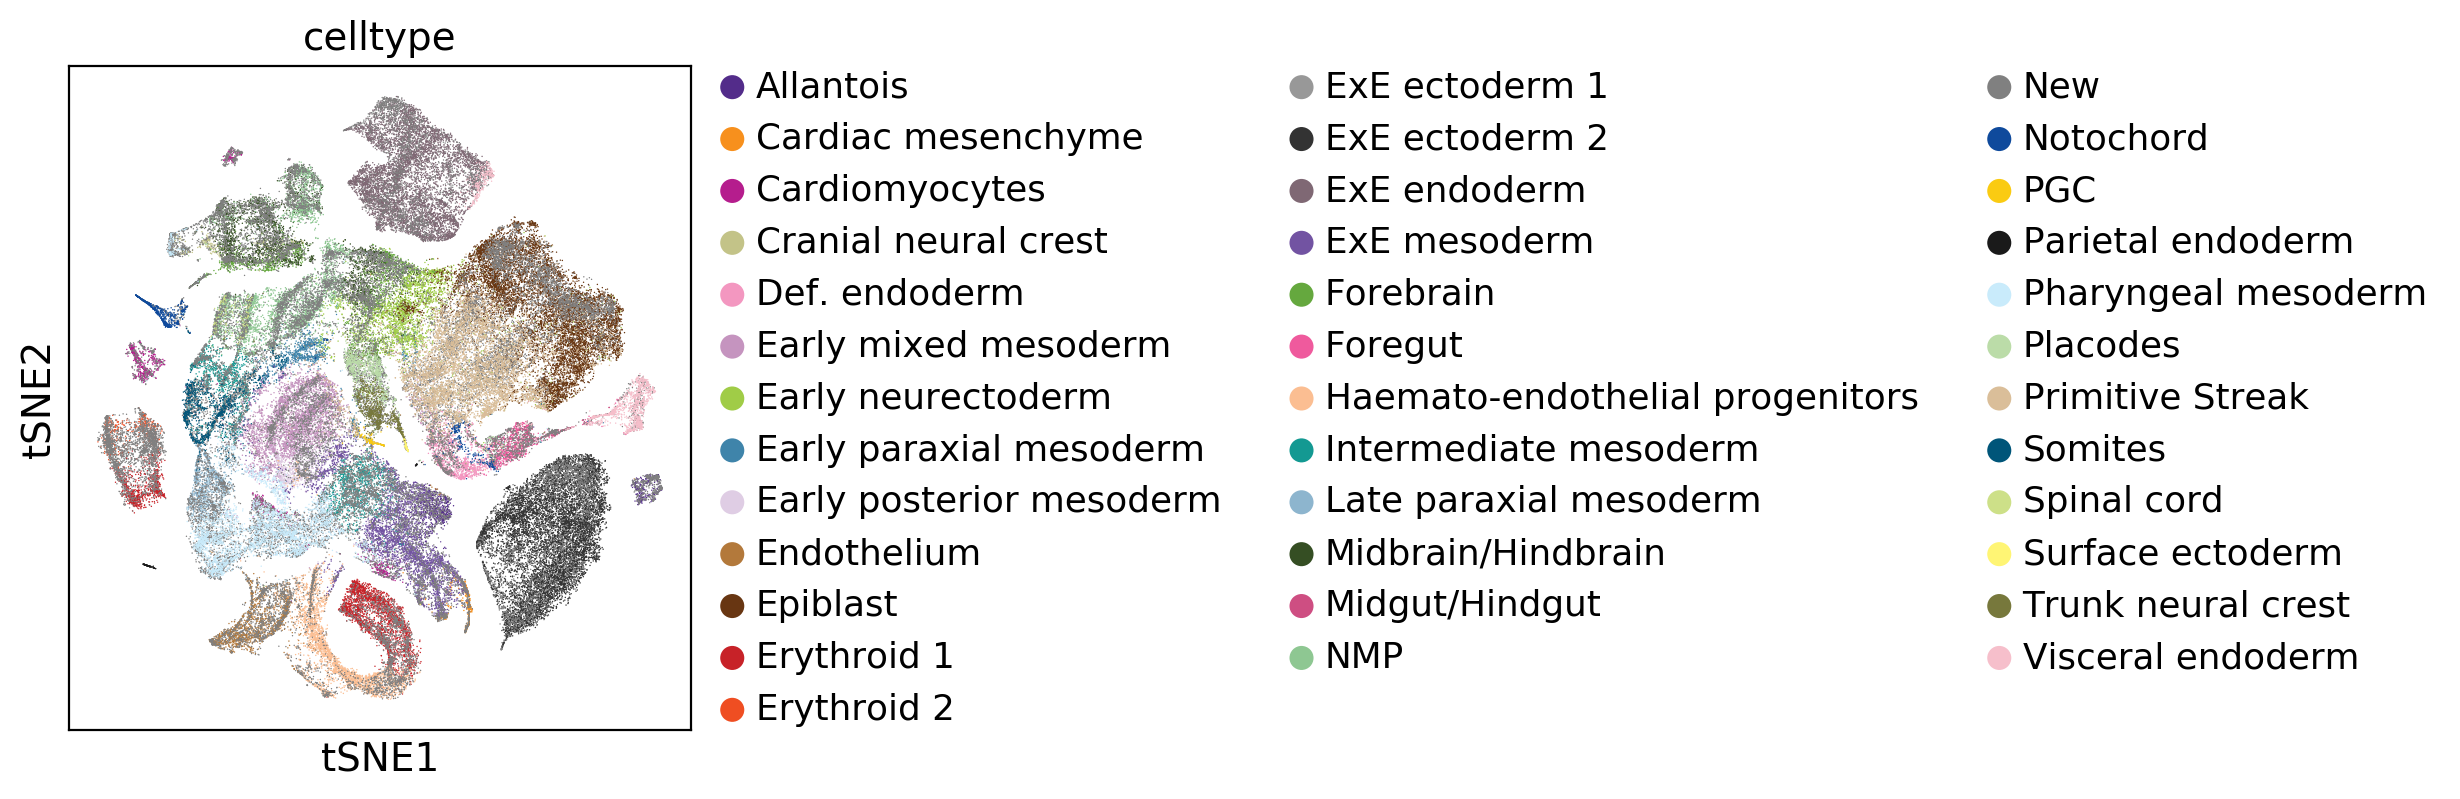

In [46]:
##======  Plot tSNE coloured by cell types ======##

sc.pl.tsne(adata,color='celltype',palette=colPalette,save="tsne_celltype.png")

saving figure to file ./figures/tsnetsne_timepoint.png


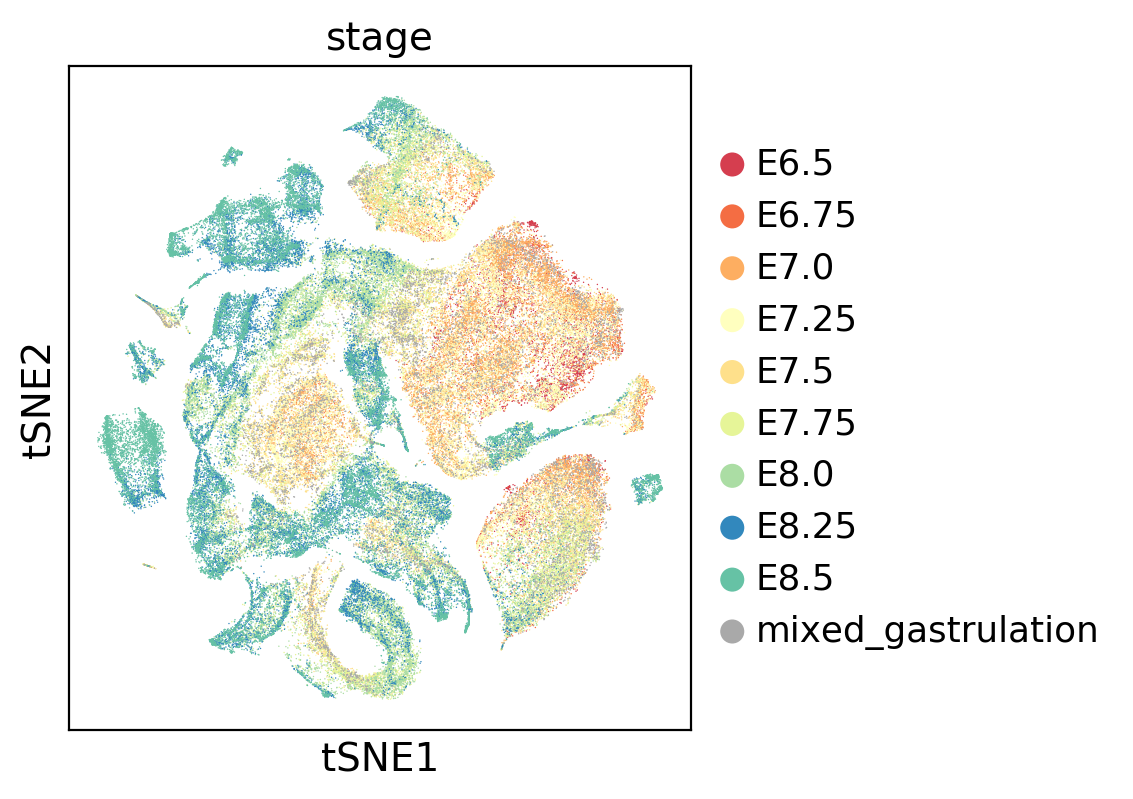

In [47]:
##======  Plot tSNE coloured by time-points ======##

sc.pl.tsne(adata,color='stage',palette=spectralPal,save="tsne_timepoint.png")

saving figure to file ./figures/umapumap_celltype.png


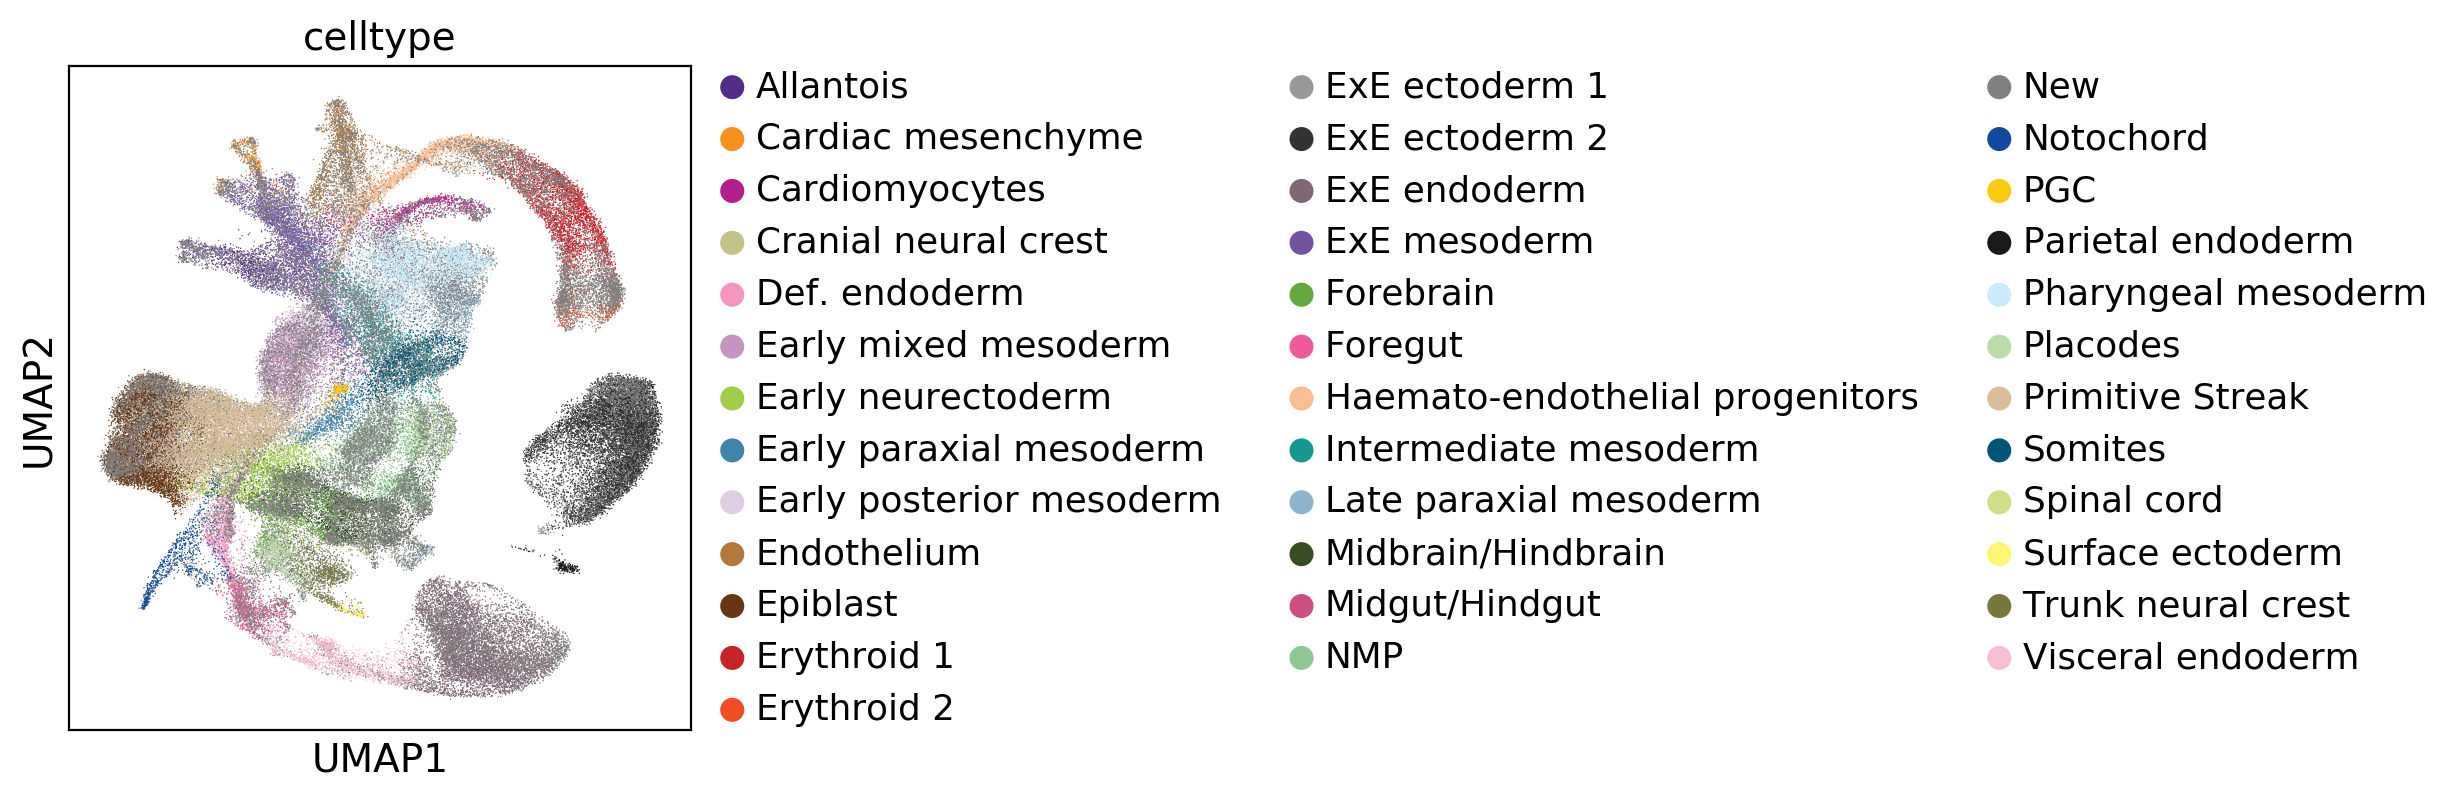

In [48]:
##======  Plot UMAP coloured by cell types ======##

sc.pl.scatter(adata,color='celltype',basis="umap",palette=colPalette,save="umap_celltype.png")

saving figure to file ./figures/umapumap_timepoint.png


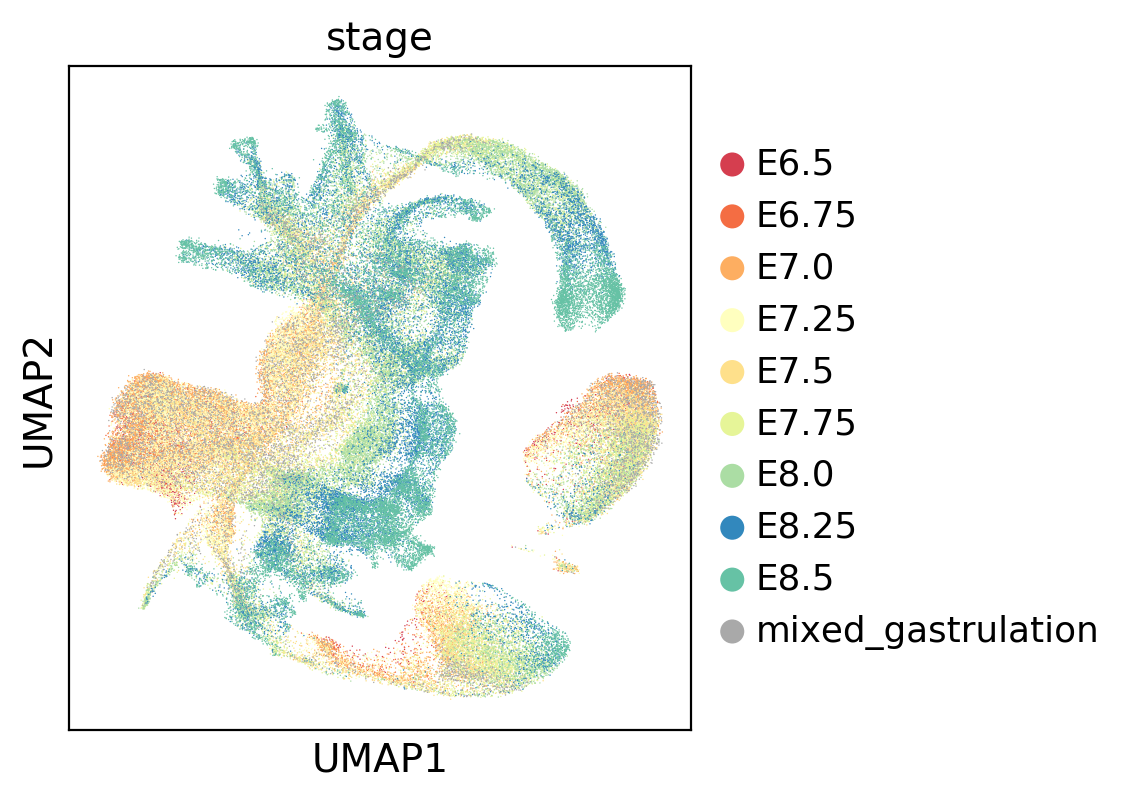

In [49]:
##======  Plot UMAP coloured by time-points ======##

sc.pl.scatter(adata,color='stage',basis="umap",palette=spectralPal,save="umap_timepoint.png")

## Merge clusters

In [40]:
##======  Read adata object ======##

adata = sc.read(results_file)


In [41]:
##======  Check number of unique clusters ======##

len(np.unique(adata.obs['clusterSubUnique']))

139

In [42]:
##======  Compute diffusion maps using the batch corrected PCA space ======##

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, use_rep='X_pca', 
                knn=True, random_state=0, method='umap', metric='euclidean', metric_kwds={}, copy=False)

sc.tl.diffmap(adata)

computing neighbors
    finished (0:01:18.46) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.9999613  0.9997717  0.99963903 0.99843466 0.99715143
     0.99659574 0.99558234 0.99542165 0.9951576  0.9948797  0.9944975
     0.9941677  0.99247    0.9917073 ]
    finished (0:00:12.57) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)


In [50]:
##======  Compute PAGA using the diffusion maps space ======##

sc.pp.neighbors(adata,n_neighbors=15,use_rep='X_diffmap')
sc.tl.paga(adata, groups='clusterSubUnique')



computing neighbors
    finished (0:00:55.40) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
running partition-based graph abstraction (PAGA)
    finished (0:00:19.23) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_comparetsne_clustersSubUnique_AGA.png


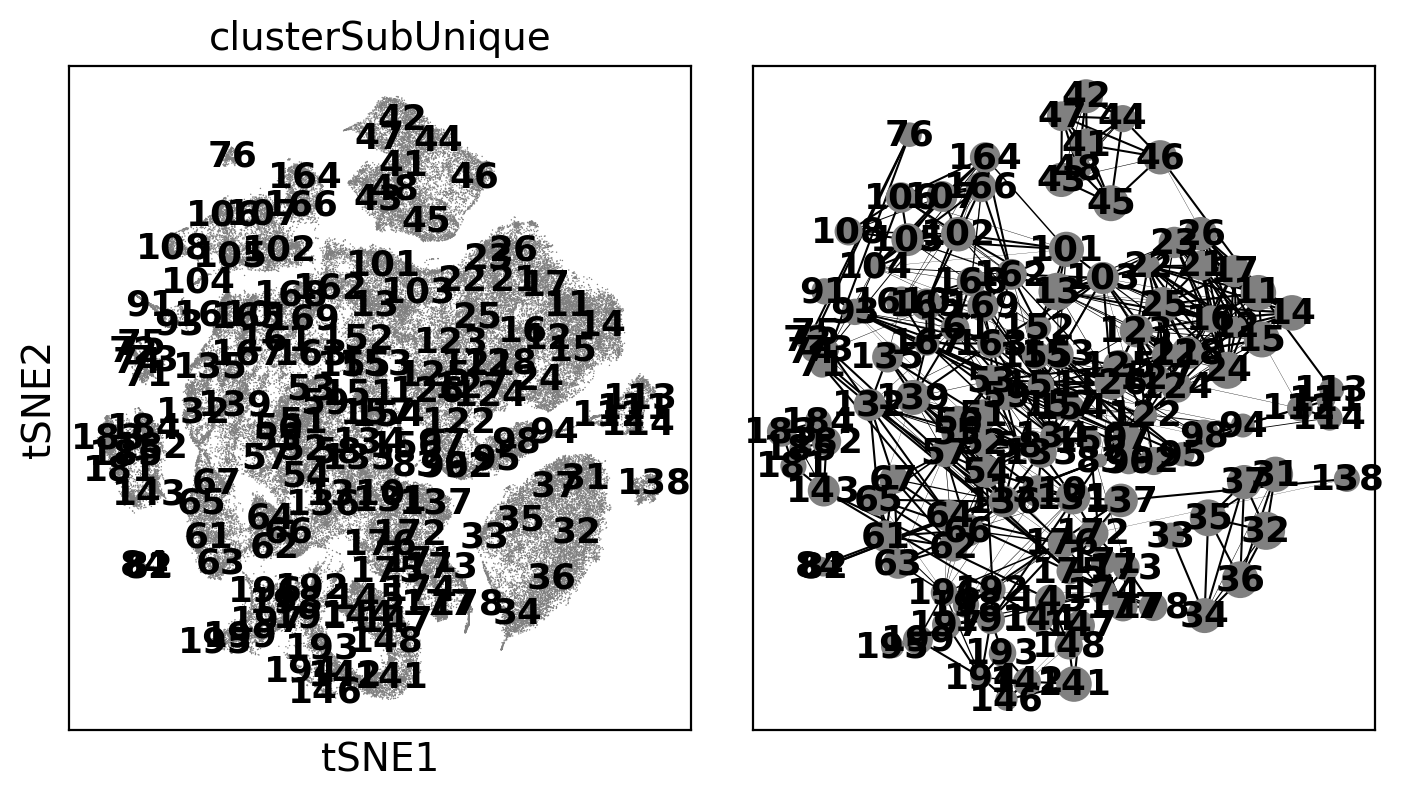

In [51]:
sc.pl.paga_compare(adata, basis='tsne',threshold_solid=0.1,edge_width_scale=0.1, save="tsne_clustersSubUnique_AGA.png")

--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_compareumap_clustersSubUnique_AGA.png


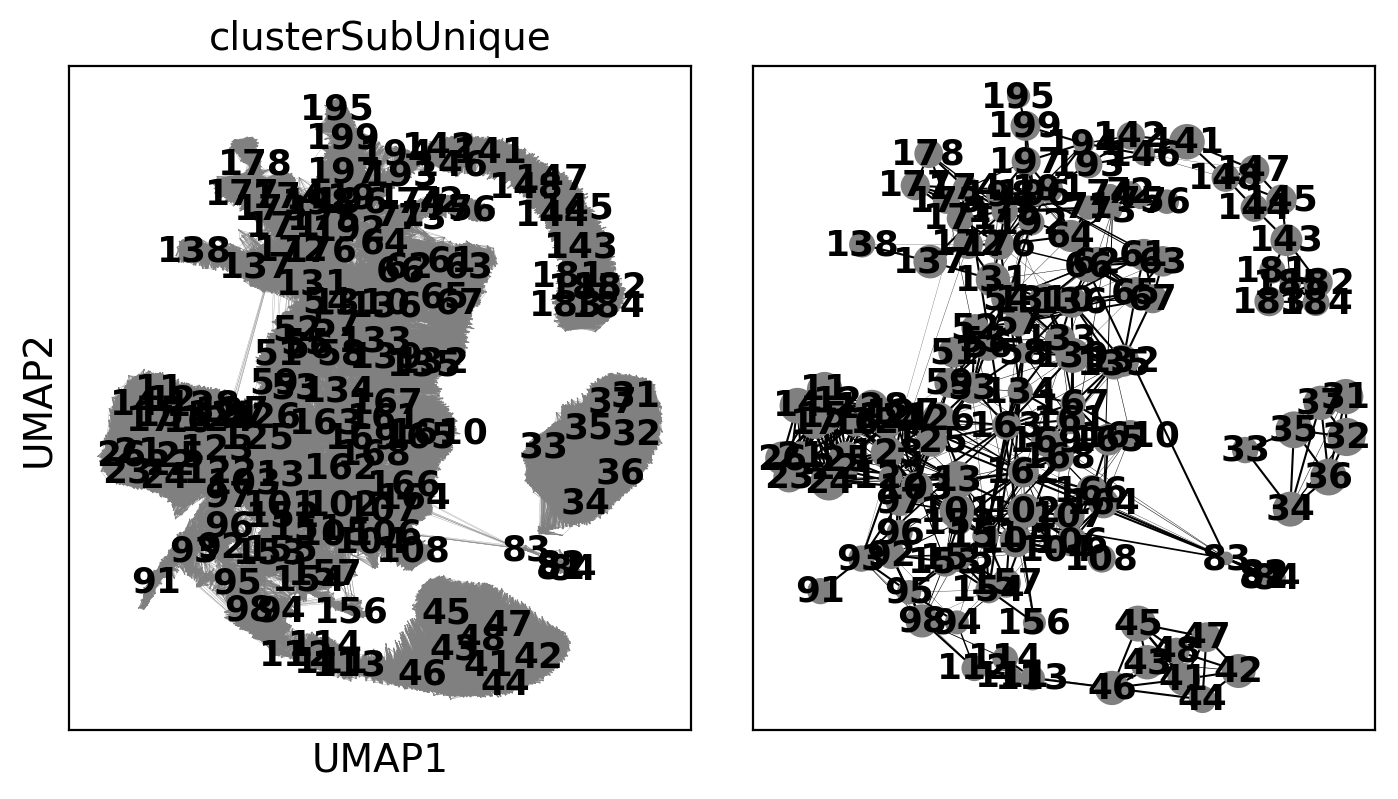

In [53]:
sc.pl.paga_compare(adata, basis='umap',threshold_solid=0.1,edge_width_scale=0.1, save="umap_clustersSubUnique_AGA.png")

/rds/user/bp382/rds-bg200-hphi-gottgens/users/bp382/00resources/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


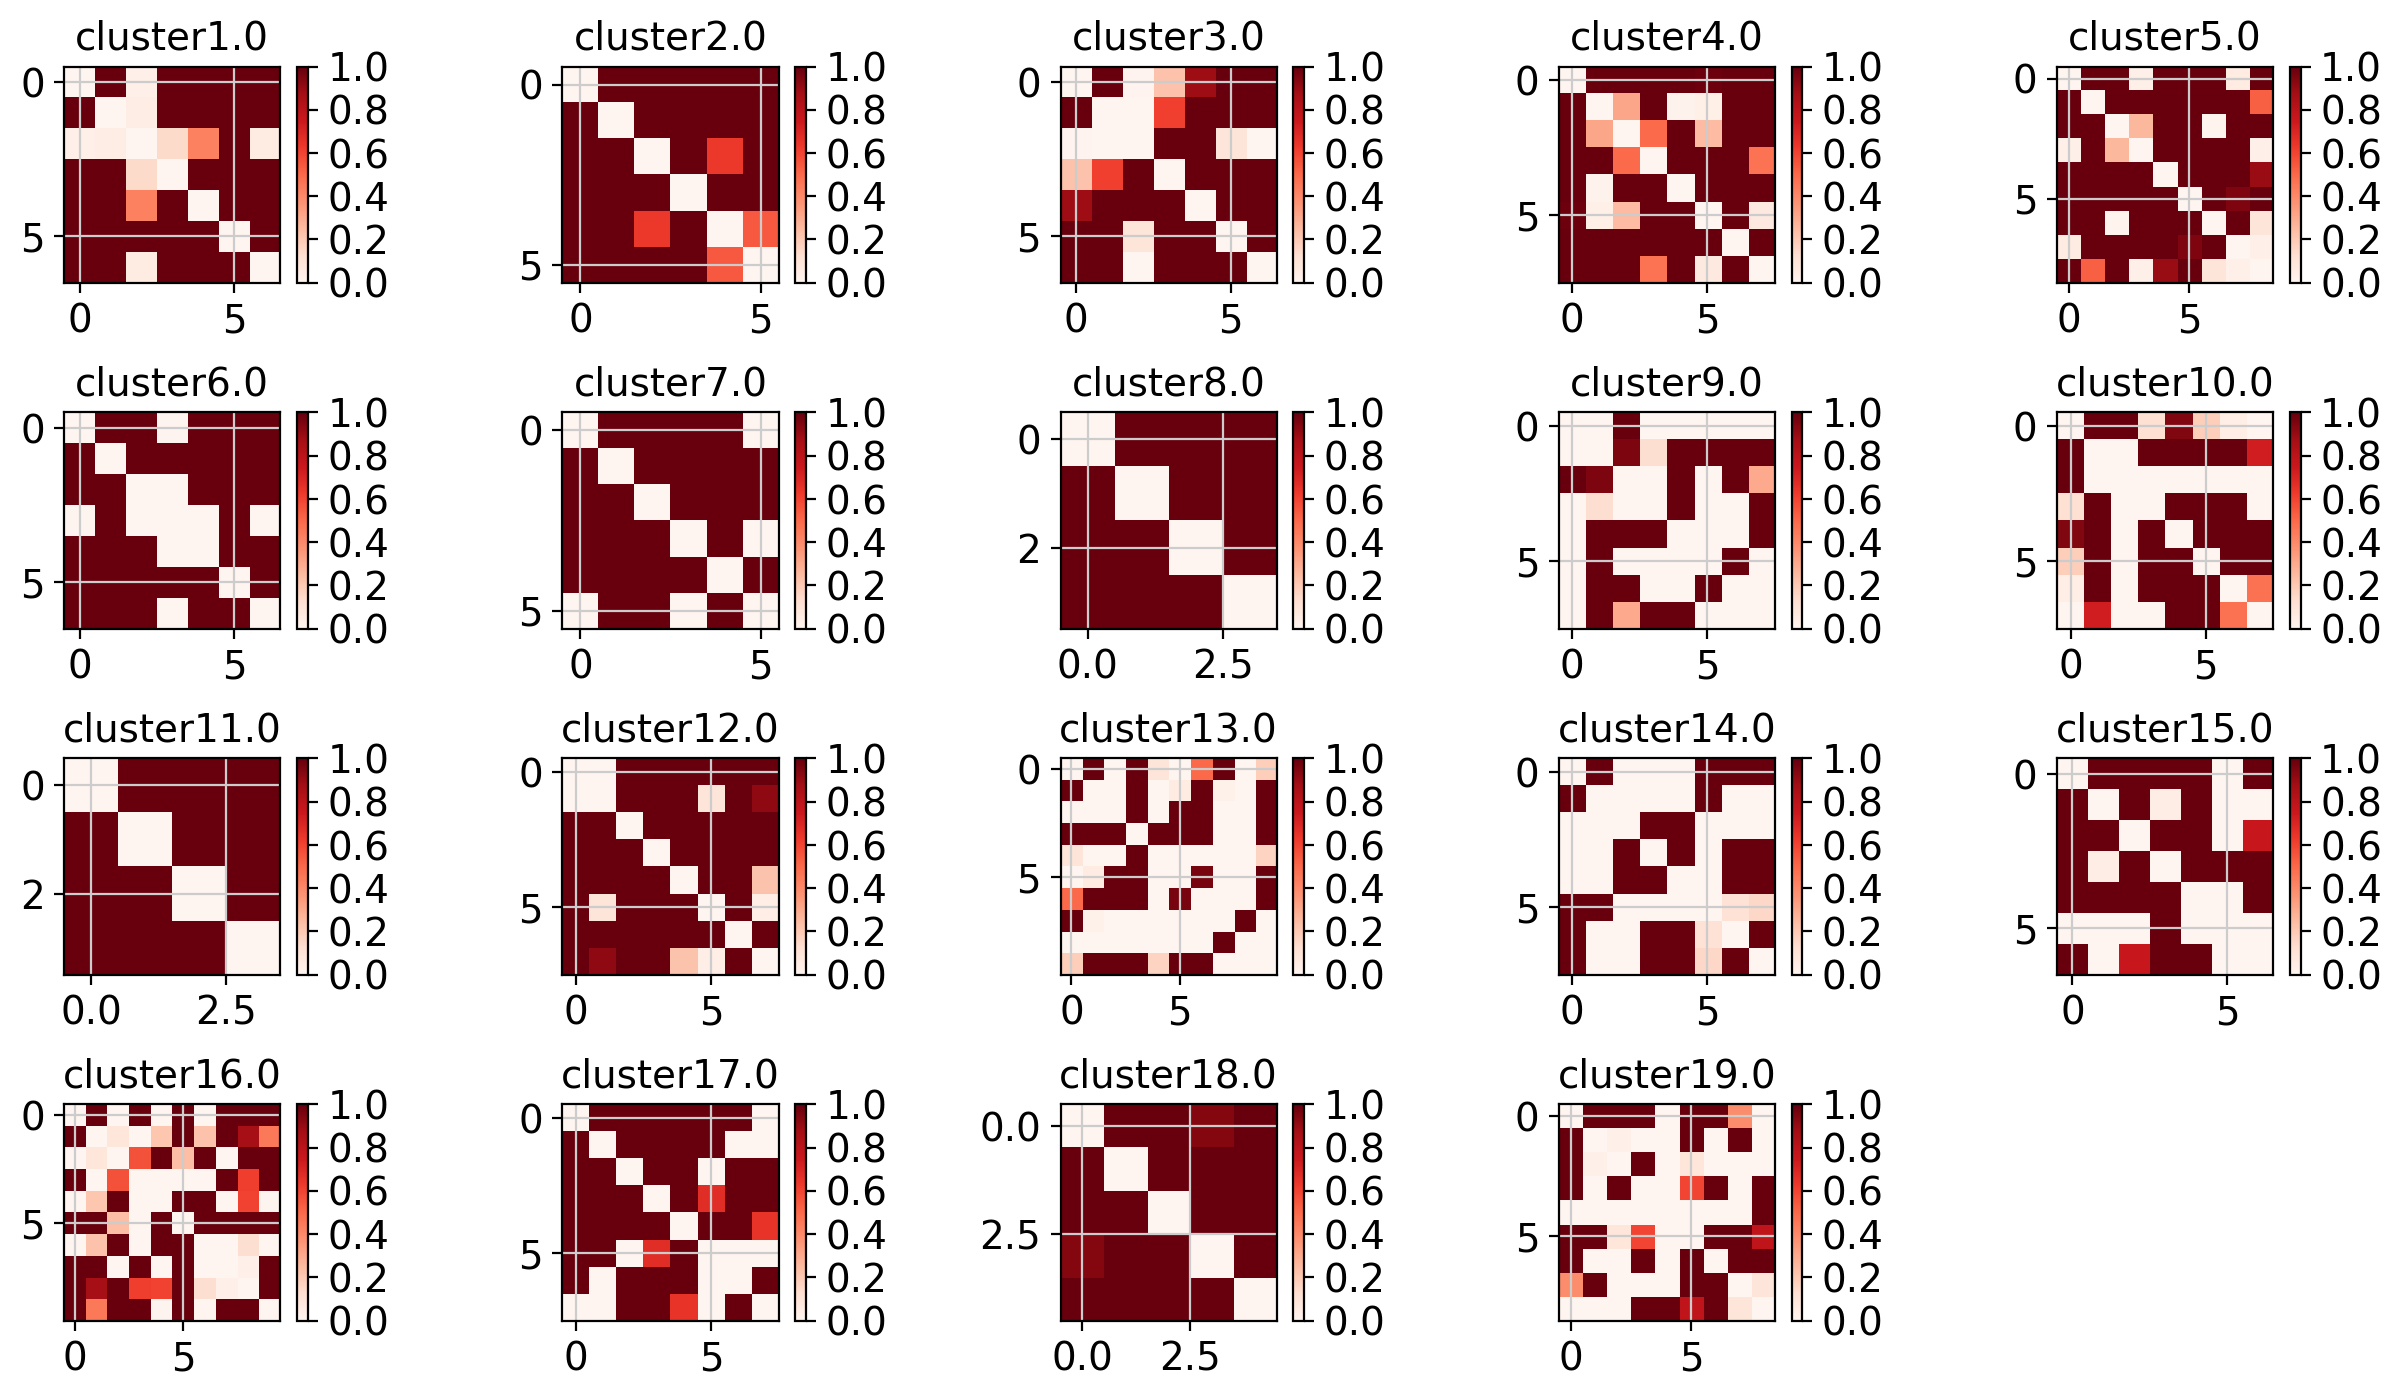

In [54]:
##======  Check how connected the subclusters within each cluster are ======##

fig = plt.figure(figsize=(15,10))
clusters = np.unique(adata.obs["cluster"])

for j in range(0,len(np.unique(adata.obs['cluster']))):

    number=clusters[j]
    
    adataSub = adata[np.array([clust == number for clust in adata.obs['cluster']]),:]
    #print("adataSub shape")
    #print(adataSub.shape)
    mat = adata.uns['paga']['connectivities'].todense()
    #print("mat shape")

    #print(mat.shape)

    #print(labelsPlot0)
    labelsPlot = number
    clusterSubUn = np.unique(adataSub.obs['clusterSubUnique'])
    #print(len(clusterSubUn))
    
    clustBool = [clust in clusterSubUn for clust in np.unique(adata.obs['clusterSubUnique'])]
    #print(clustBool)
   # print(mat.shape)
   # print(len(clustBool))
    matsub = mat[clustBool,:][:,clustBool]
    
    plt.subplot(5,5,j+1)
    #print(matsub.shape)
    plt.imshow(matsub, cmap='Reds', interpolation='nearest',vmin=0,vmax=1)
    plt.title('cluster'+str(labelsPlot))
    plt.colorbar()
    plt.grid(True)

    #print(matsub)
plt.subplots_adjust(
    left  = 0.125,  # the left side of the subplots of the figure
    right = 0.9,    # the right side of the subplots of the figure
    bottom = 0.1,   # the bottom of the subplots of the figure
    top = 0.9,      # the top of the subplots of the figure
    wspace = 0.5,   # the amount of width reserved for blank space between subplots
    hspace = 0.6 )  # the amount of height reserved for white space between subplots
fig.show()
fig.savefig('./figures/AdjacencyMatrices_subclusters.pdf', bbox_inches='tight')

/rds/user/bp382/rds-bg200-hphi-gottgens/users/bp382/00resources/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
/rds/user/bp382/rds-bg200-hphi-gottgens/users/bp382/00resources/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
/rds/user/bp382/rds-bg200-hphi-gottgens/users/bp382/00resources/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
/rds/user/bp382/rds-bg200-hphi-gottgens/users/bp382/00resources/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observ

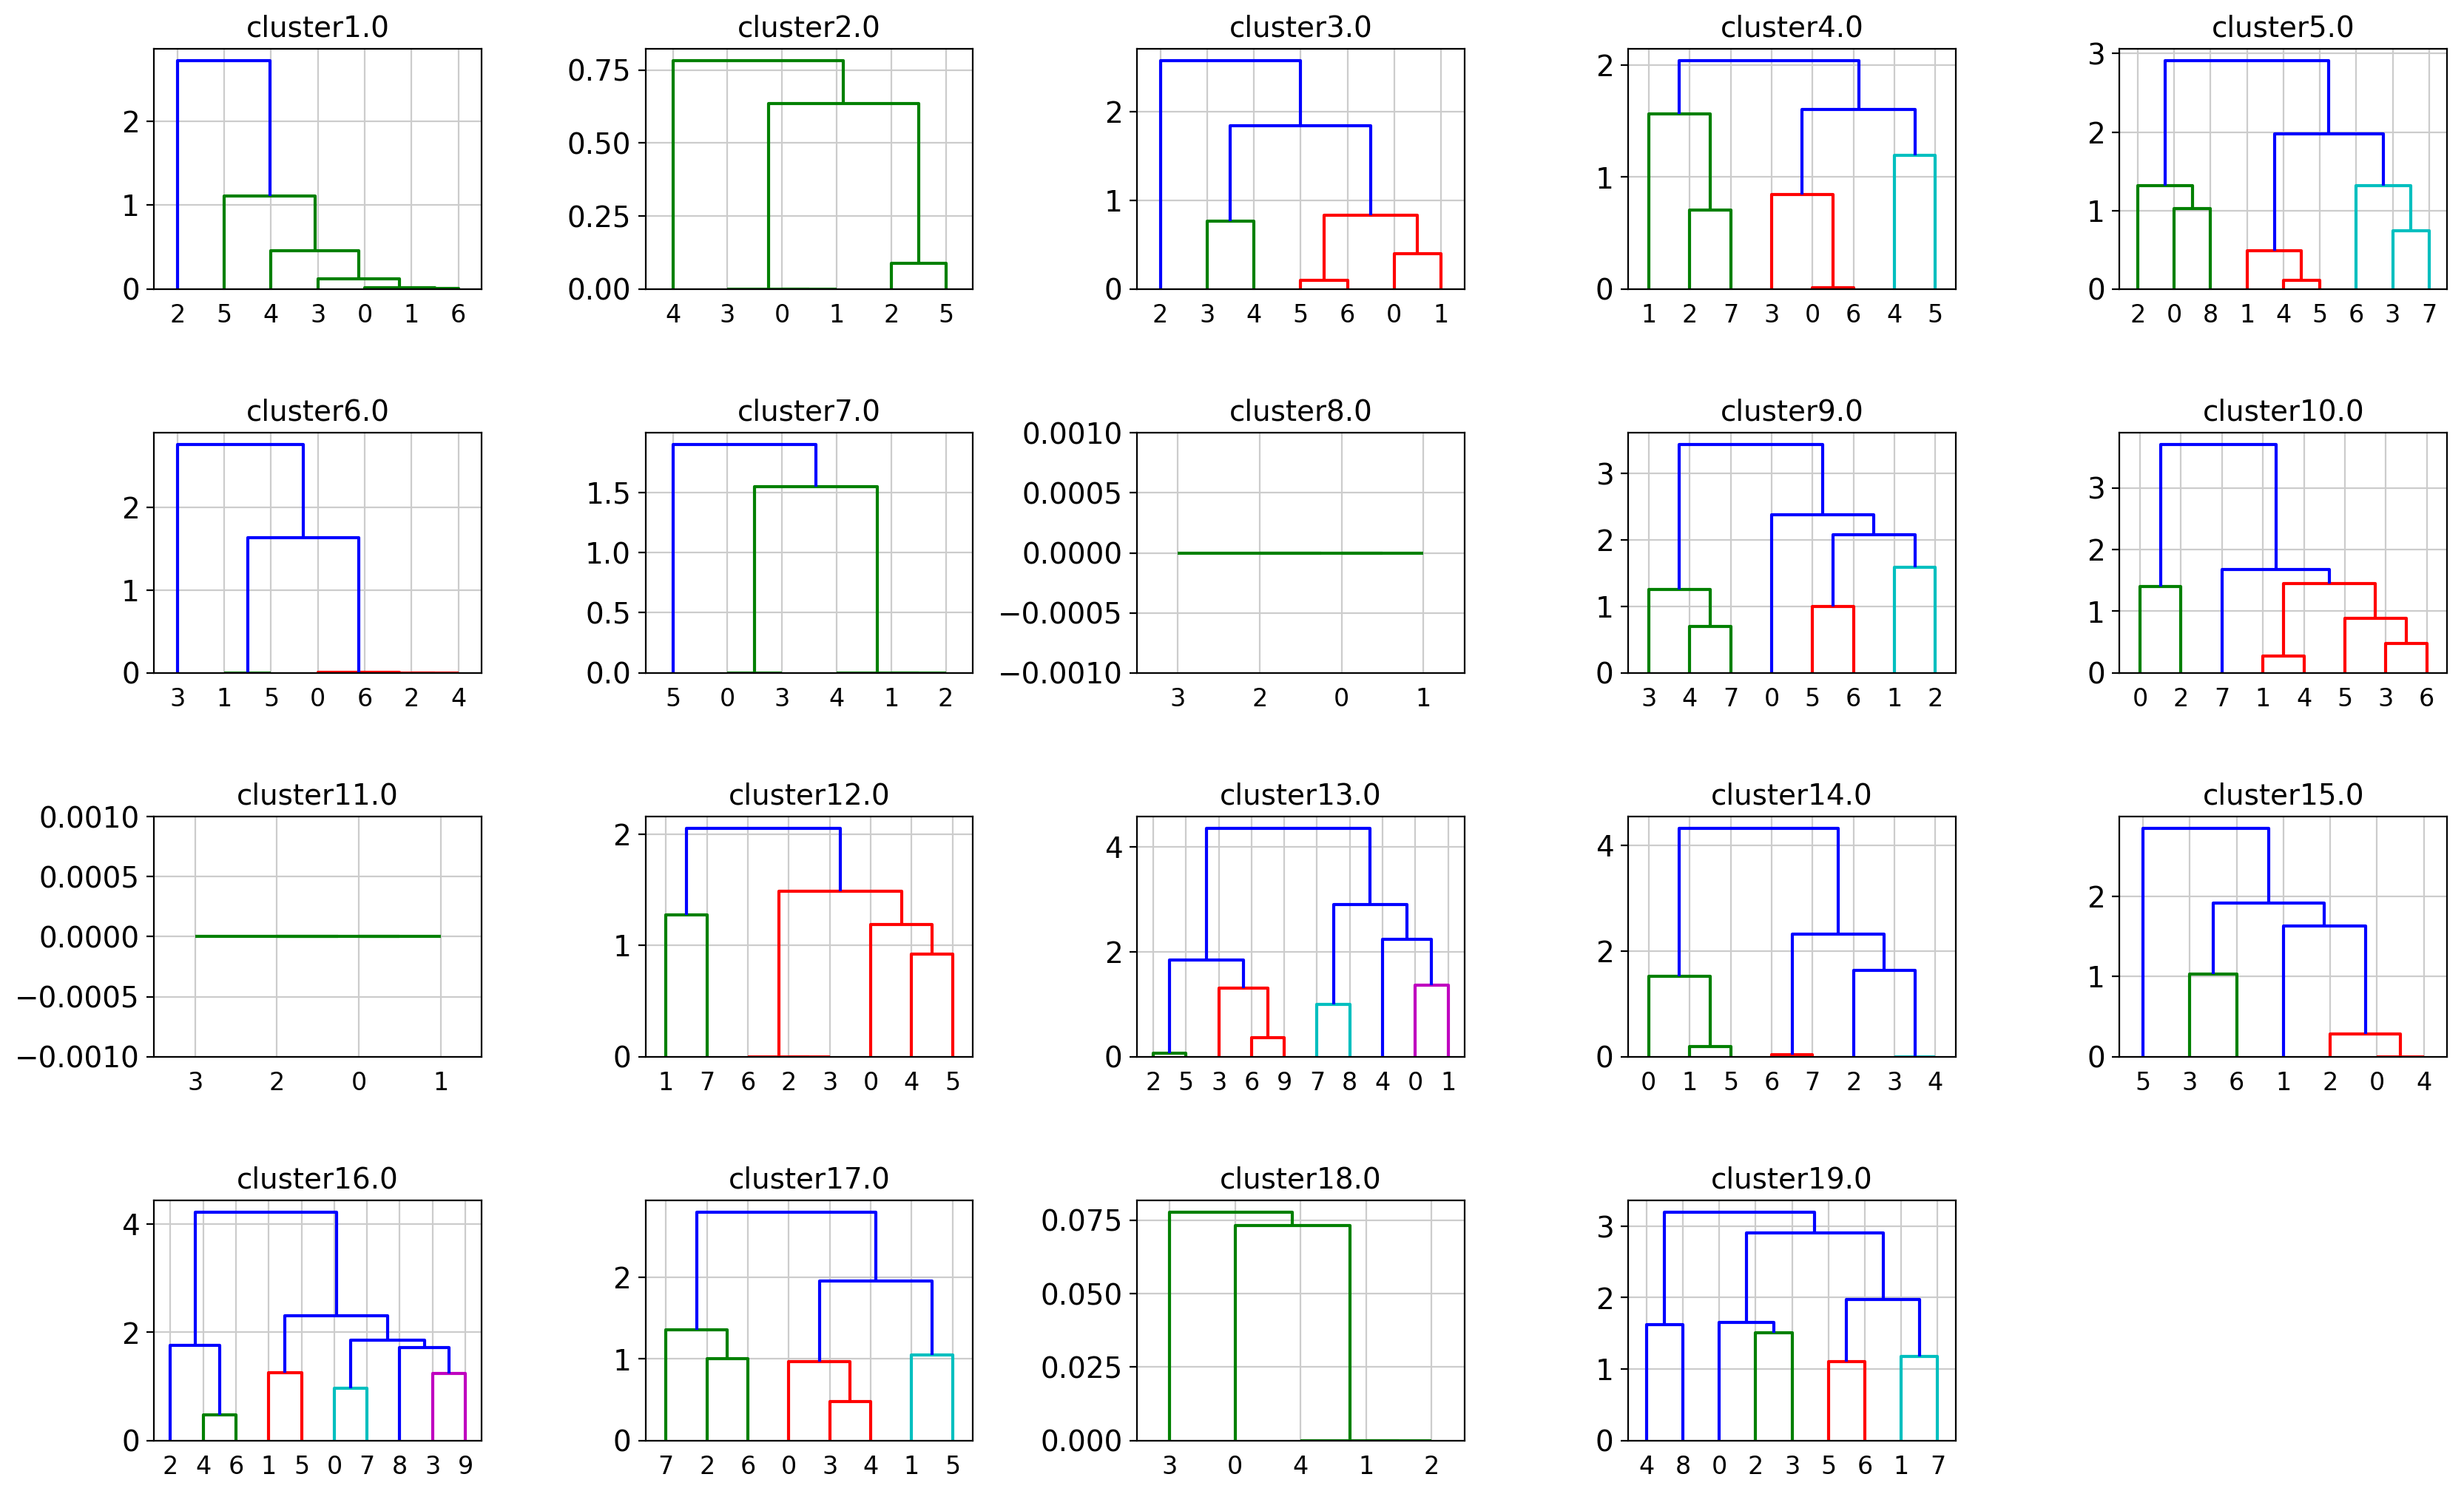

In [55]:
##======  Merge and separate subclusters setting a threshold where dendrograms should split ======##
##======  As a positive control of something that needs to be separated, use the PGCs ======##


clusters = np.unique(adata.obs["cluster"])

dictNewClust = {}
fig2 = plt.figure(figsize=(20,15))
from scipy import cluster

from scipy.cluster.hierarchy import dendrogram, linkage

#adata = sc.read(results_file2)
thres = 1.6
def getMaxIdx(data):
    np.arg.max(data)
    
sepClust = list()

for j in range(0,len(np.unique(adata.obs['cluster']))):
    
    number=clusters[j]
    
    adataSub = adata[np.array([clust == number for clust in adata.obs['cluster']]),:]
    #print("adataSub shape")
    #print(adataSub.shape)
    mat = adata.uns['paga']['connectivities'].todense()
    #print("mat shape")

    #print(mat.shape)
    labelsPlot = number
    clusterSubUn = np.unique(adataSub.obs['clusterSubUnique'])
   # print(clusterSubUn)
    
    clustBool = [clust in clusterSubUn for clust in np.unique(adata.obs['clusterSubUnique'])]
    #print(clustBool)
   # print(mat.shape)
   # print(len(clustBool))
    matsub = mat[clustBool,:][:,clustBool]
    
    matdist = 1-matsub

    np.fill_diagonal(matdist,0)
        #print(lk)
    lk = linkage(matdist, "ward")
    cutree = cluster.hierarchy.cut_tree(lk, height=thres)
  #  print(cutree)
    for q in range(0,len(list(cutree))):
        name= 'cluster'+ str(clusterSubUn[q])
        dictNewClust[name] = cutree[q]
        
        #print(cutree[q])
   # print(dictNewClust)
    
    
    
    plt.subplot(5,5,j+1)

    dendrogram(lk,color_threshold=thres)
    plt.title('cluster'+str(labelsPlot))
    plt.grid(True)

   
    #maxVal = np.apply_along_axis(max, axis=1, arr=matsub )
    #print(maxVal)
    
    #a = list([i < thres for i in maxVal ])
    #print(a)
    #print(enumerate(a))
    #aIdx =  [i for i, x in enumerate(a) if x]
    #print(aIdx)
    #if a.any():
    #    for k in list(clusterSubUn[aIdx]):
    #        sepClust.append(float(k))
                
plt.subplots_adjust(
    left  = 0.125,  # the left side of the subplots of the figure
    right = 0.9,    # the right side of the subplots of the figure
    bottom = 0.1,   # the bottom of the subplots of the figure
    top = 0.9,      # the top of the subplots of the figure
    wspace = 0.5,   # the amount of width reserved for blank space between subplots
    hspace = 0.6 )  # the amount of height reserved for white space between subplots
fig2.show()
fig2.savefig('./figures/Dendrograms_subclusters.pdf', bbox_inches='tight')


In [56]:
##======  Get merged subclustering annotation and add it to adata object ======##

dictCells = {}
for i in range(0,len(np.unique(list(adata.obs['cluster'])))):
    number = np.unique(list(adata.obs['cluster']))[i]
    #print(number)
    adataSub = adata[np.array([clust == number for clust in adata.obs['cluster']]),:]
    
    uniqueClust = np.unique(list(adataSub.obs['clusterSubUnique']))
   # print(uniqueClust)
    listClust = list()
    for j in uniqueClust:
        dictCells[(str(j))] = (str(int(number))+ str(int(dictNewClust['cluster'+str(j)])))
        
    #print("\n")

    
dictcells0 = pd.DataFrame.from_dict(dictCells,orient='index',columns=["merged"])


adata.obs['clusterMergedHierarchy'] = list(dictcells0.loc[adata.obs['clusterSubUnique'],'merged'])



In [57]:
##======  Check number of merged subclusters ======##

len(np.unique(adata.obs['clusterMergedHierarchy']))

57

In [58]:
##======  Write results ======##

sc.write(results_file,adata)

## tSNE, UMAP and graph abstraction of merged subclusters

In [59]:
##======  Read adata object ======##

adata = sc.read(results_file)

In [60]:
##======  Compute PAGA on merged subclusters ======##


sc.pp.neighbors(adata,n_neighbors=15,use_rep='X_diffmap')
sc.tl.paga(adata, groups='clusterMergedHierarchy')

computing neighbors
    finished (0:00:57.59) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
running partition-based graph abstraction (PAGA)
    finished (0:00:08.62) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_comparetsne_clustersMerged_AGA.png


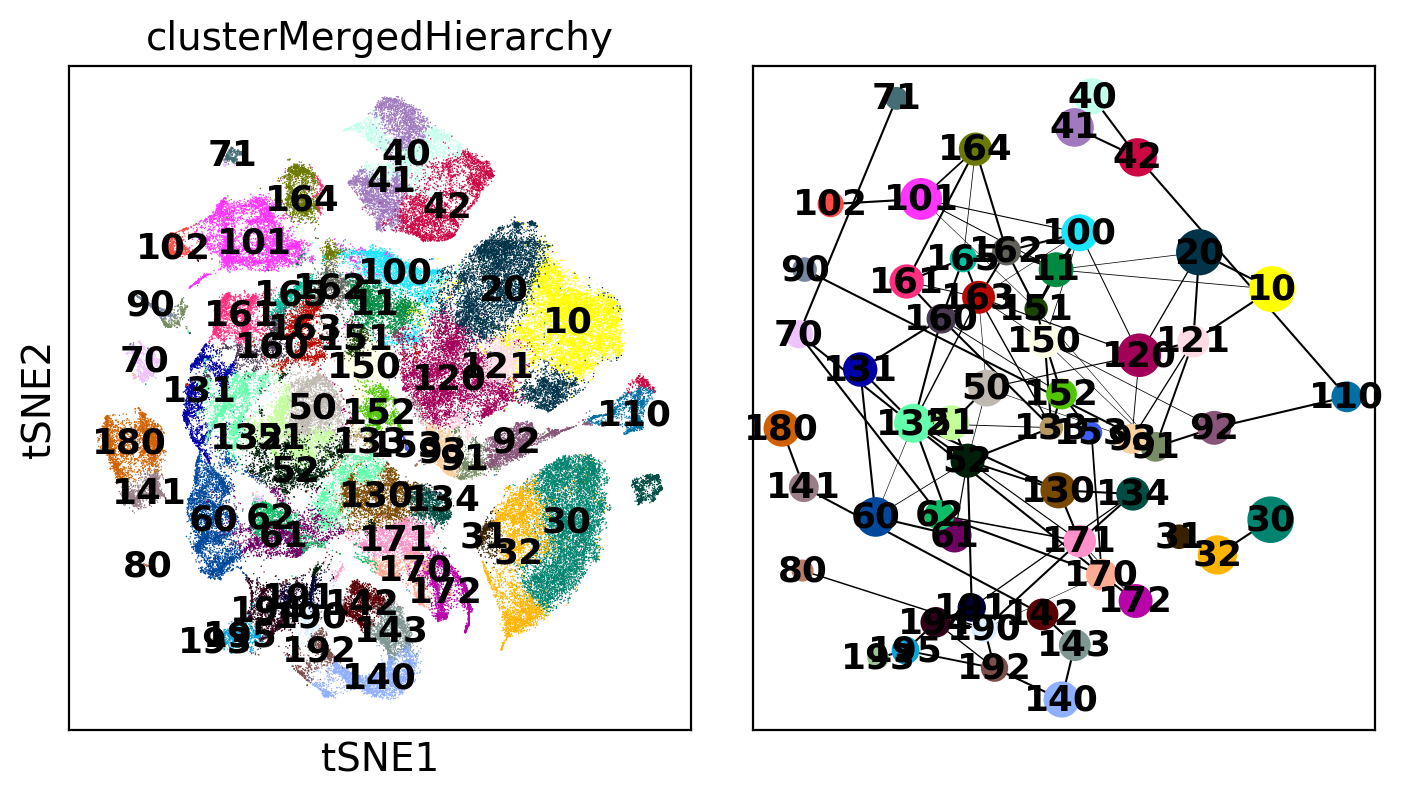

In [61]:
##======  Plot tSNE and PAGA coloured by merged subclusters ======##

sc.pl.paga_compare(adata, basis='tsne',threshold_solid=0.25,edge_width_scale=0.1,save="tsne_clustersMerged_AGA.png")

--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_comparetsne_clustersMerged_AGA.png


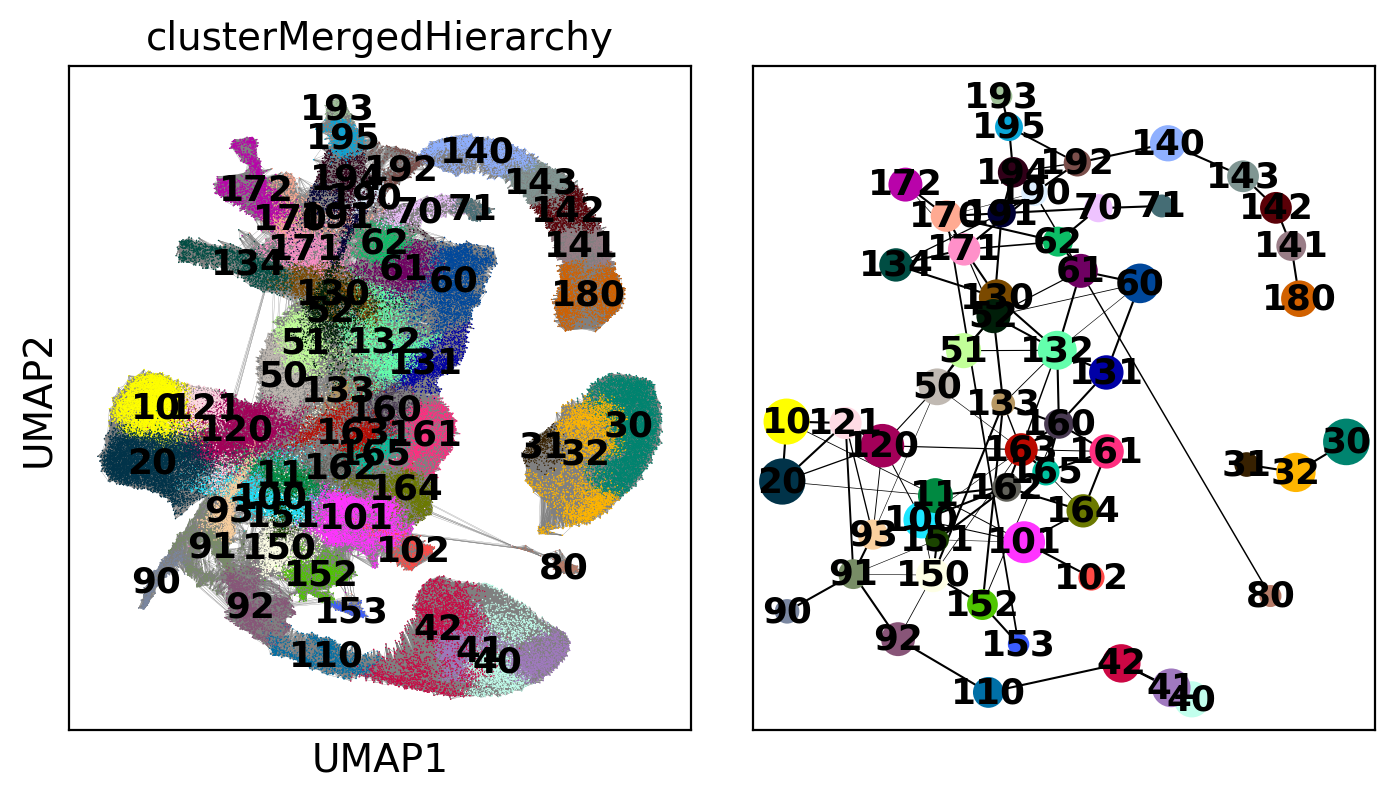

In [62]:
sc.pl.paga_compare(adata, basis='umap',threshold_solid=0.25,edge_width_scale=0.1,save="tsne_clustersMerged_AGA.png")

--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/pagaclustersMerged_AGA.png


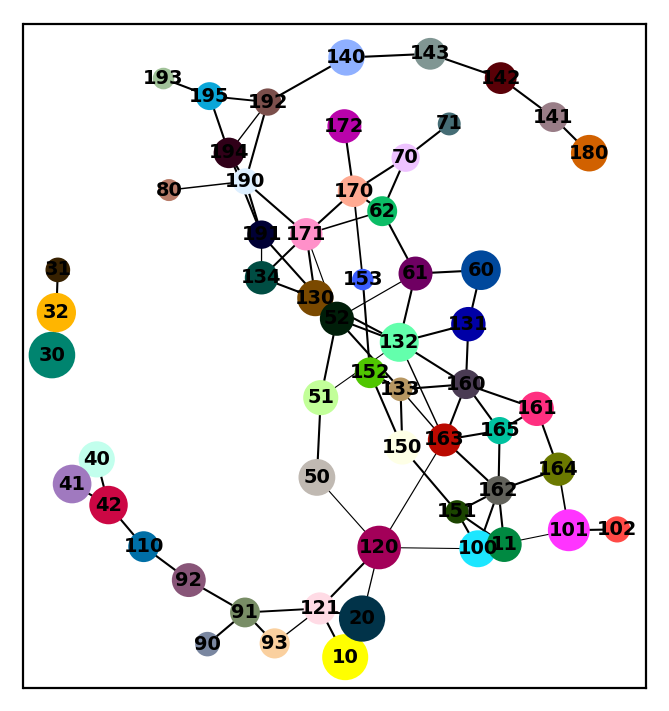

In [63]:
##======  Plot PAGA coloured by merged subclusters ======##

sc.pl.paga(adata, threshold_solid=0.5,fontsize=7,edge_width_scale=0.1,save="clustersMerged_AGA.png")

In [64]:
##======  Write results ======##

sc.write(results_fileMerged,adata)

## Metadata - writing merged subclusters

In [96]:
##======  Write metadata with merged subclusters ======##

metadataWrite = pd.DataFrame(data=adata.obs)
metadataWrite.to_csv('metadata_mergedSubclusters.txt', sep='\t')